Using cpu device
Done!0


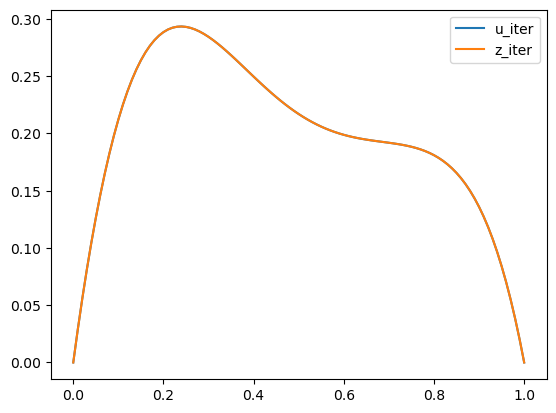

Done!1


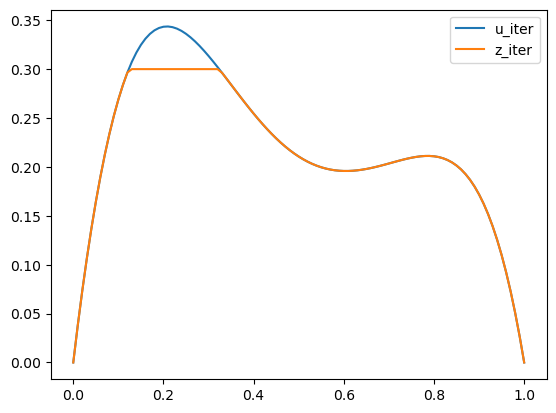

Done!2


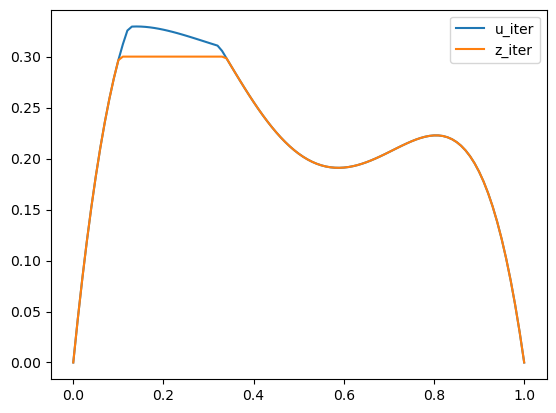

Done!3


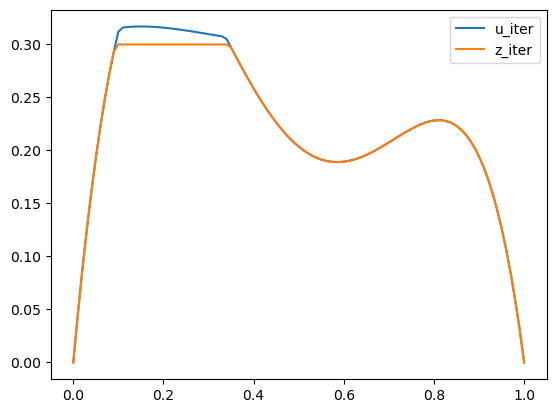

Done!4


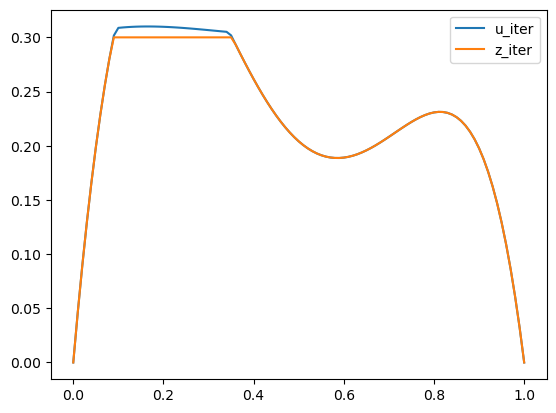

Done!5


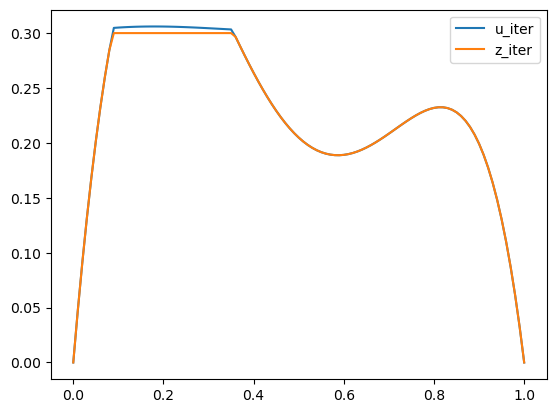

Done!6


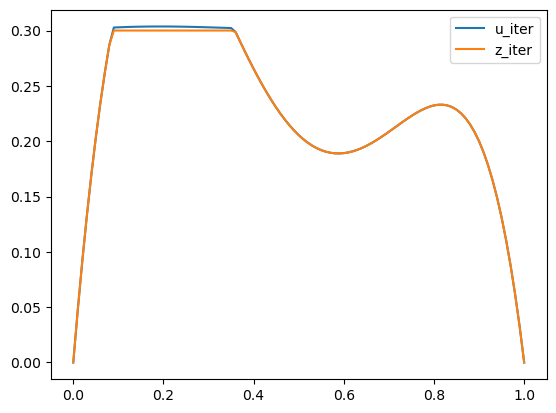

Done!7


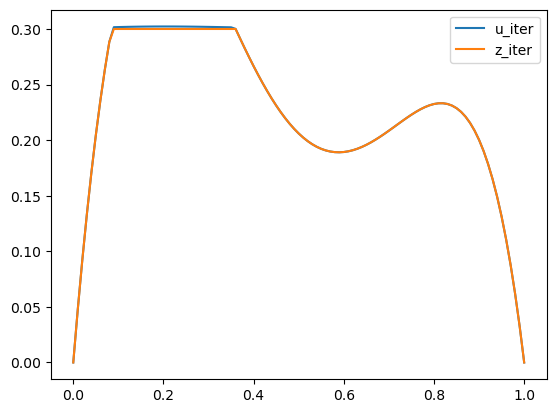

Done!8


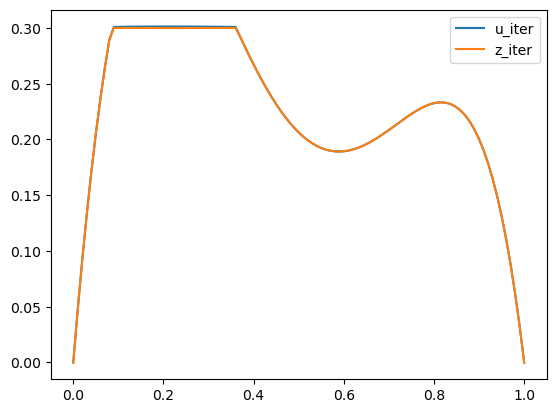

Done!9


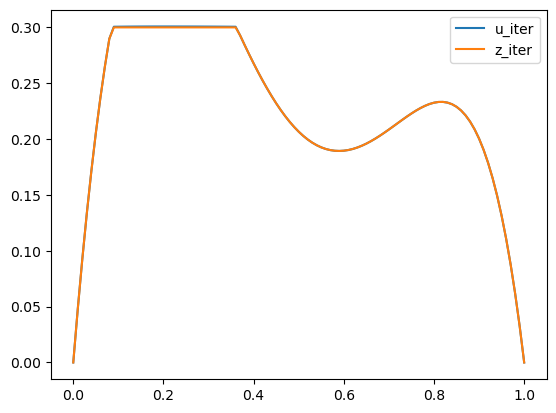

Done!10


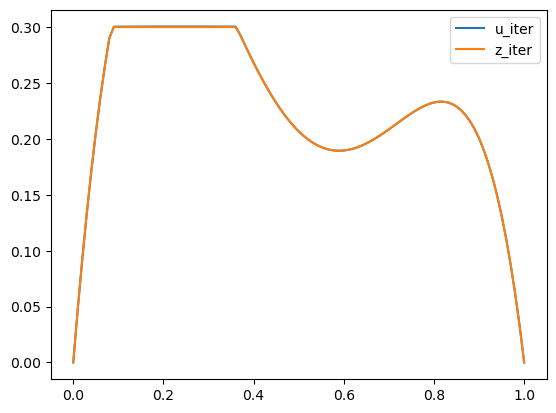

Done!11


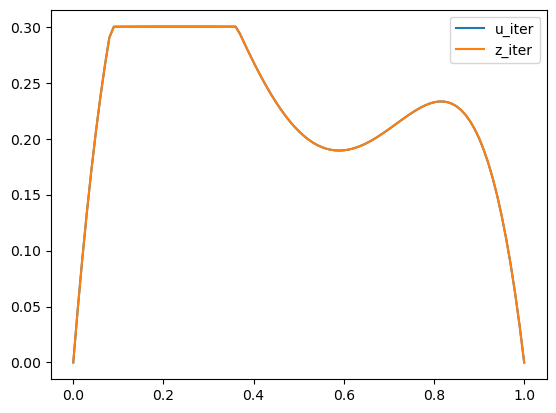

Done!12


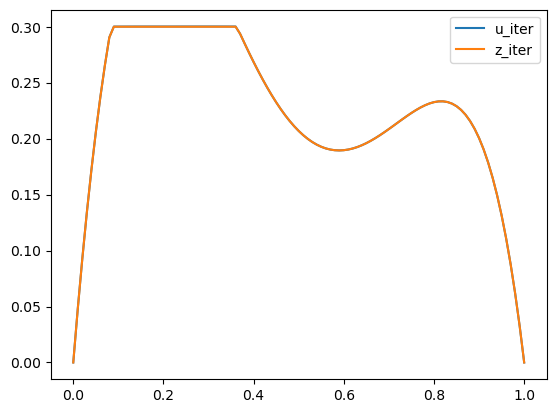

Done!13


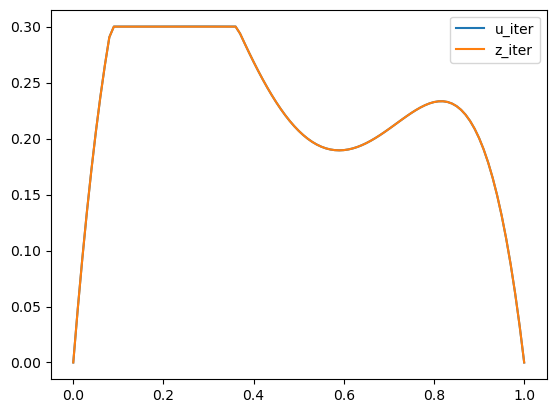

Done!14


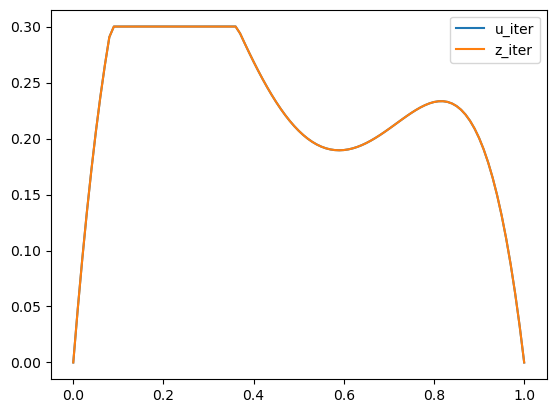

Done!15


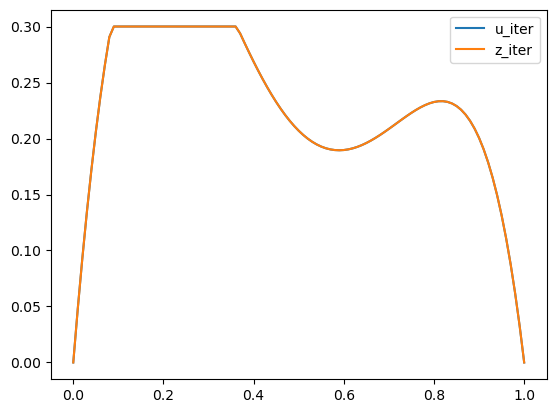

Done!16


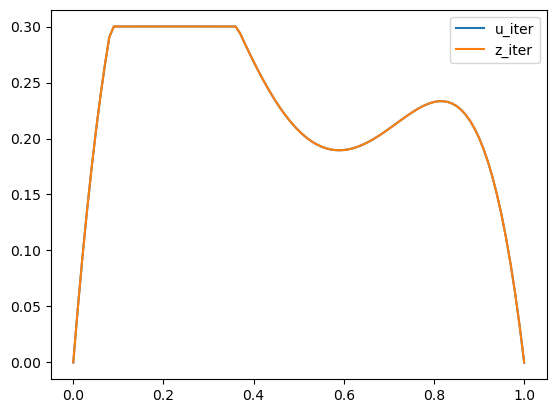

Done!17


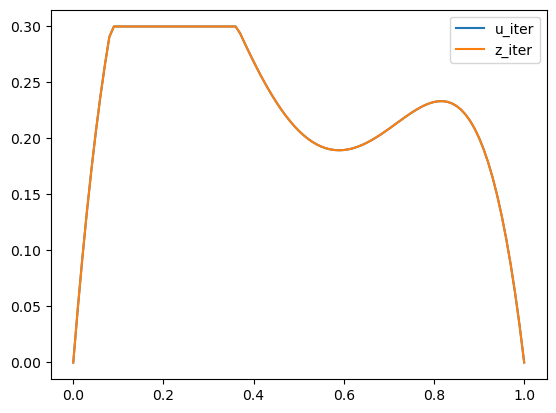

Done!18


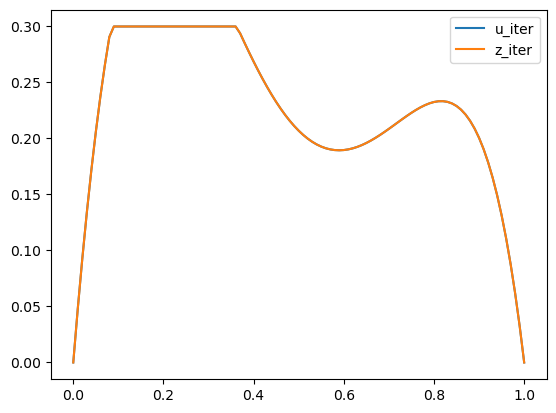

Done!19


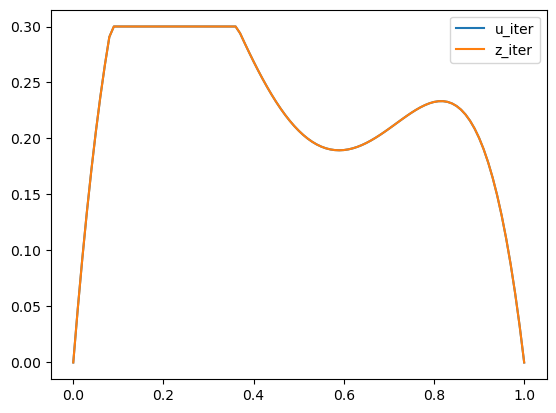

Done!20


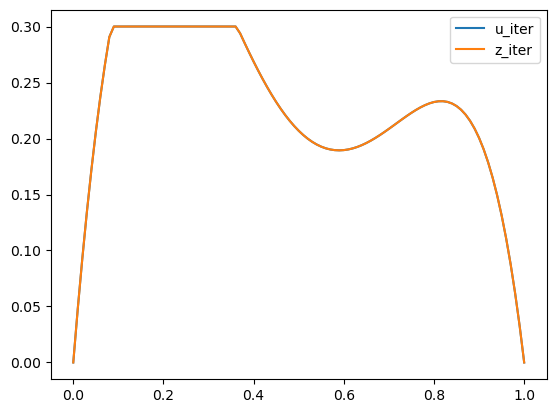

Done!21


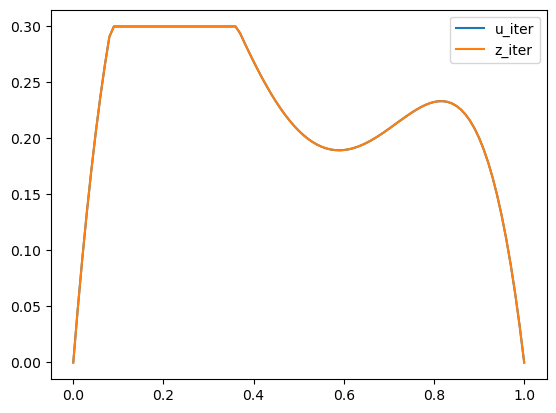

Done!22


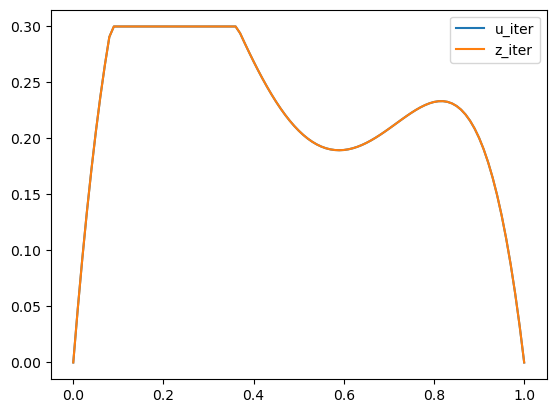

Done!23


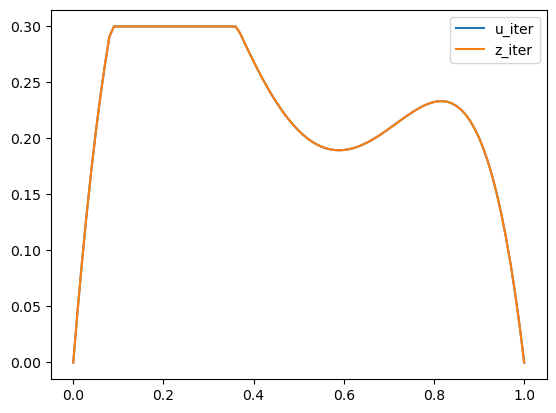

Done!24


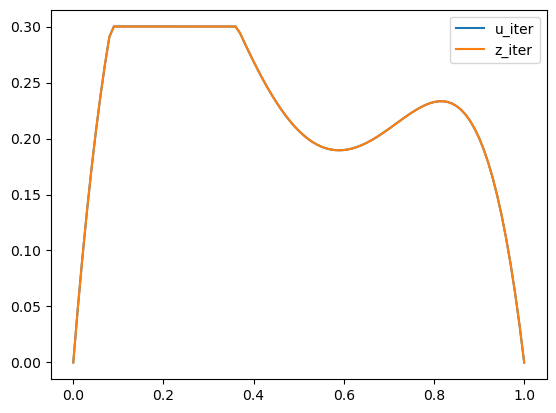

Done!25


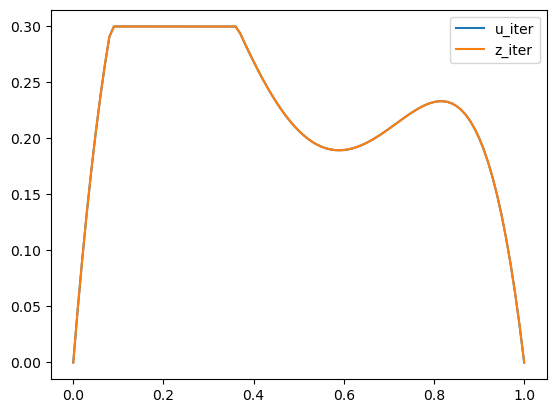

Done!26


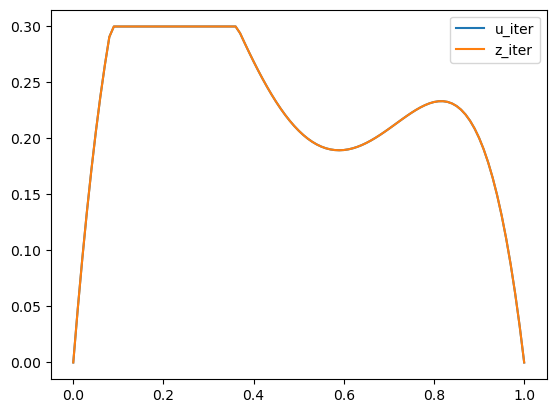

Done!27


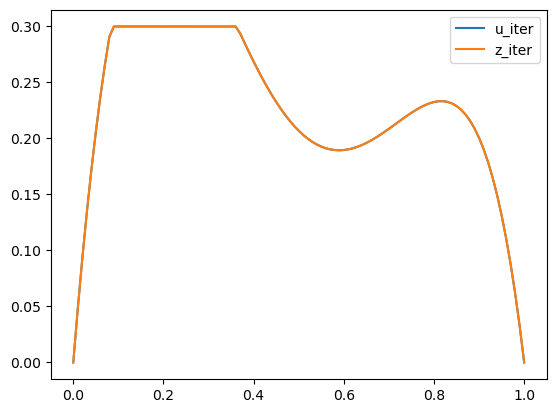

Done!28


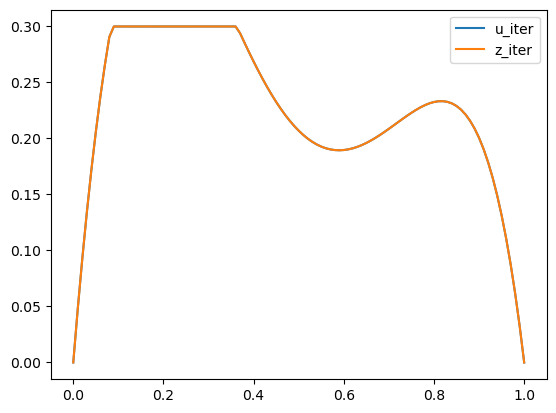

Done!29


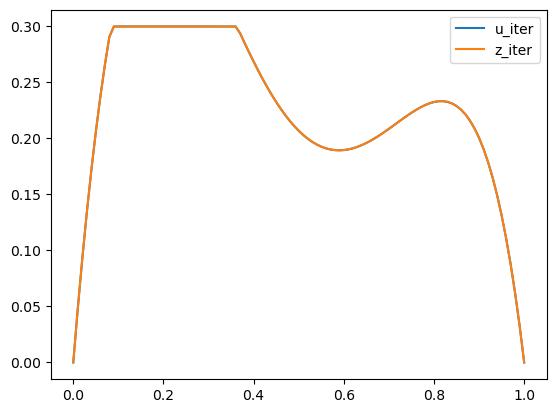

Done!30


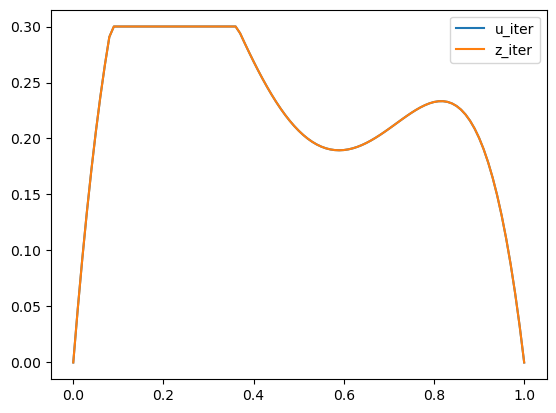

Done!31


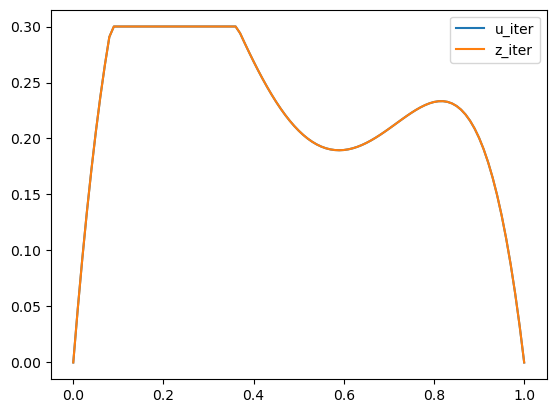

Done!32


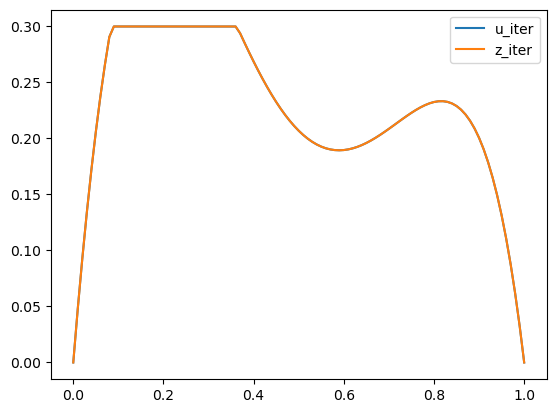

Done!33


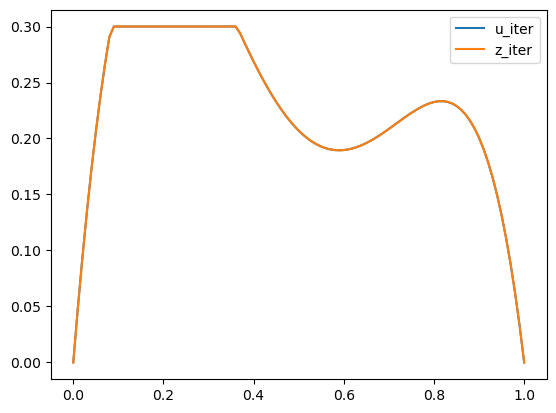

Done!34


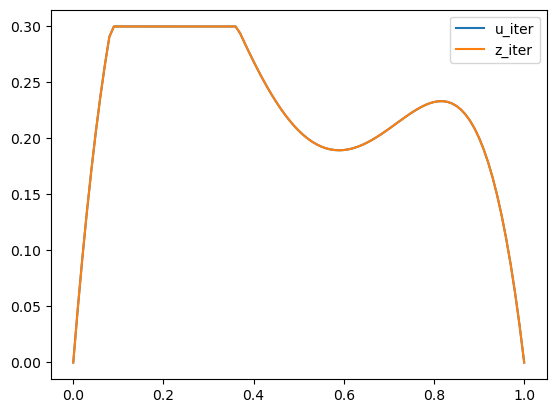

Done!35


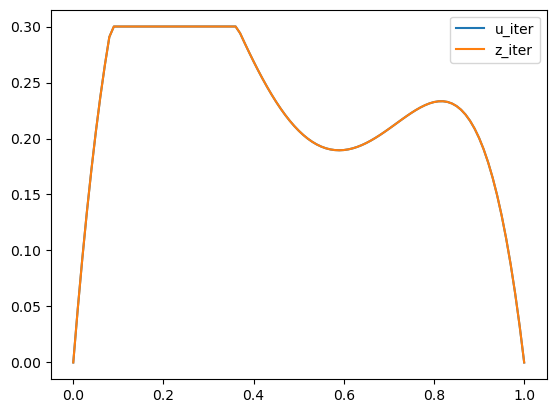

Done!36


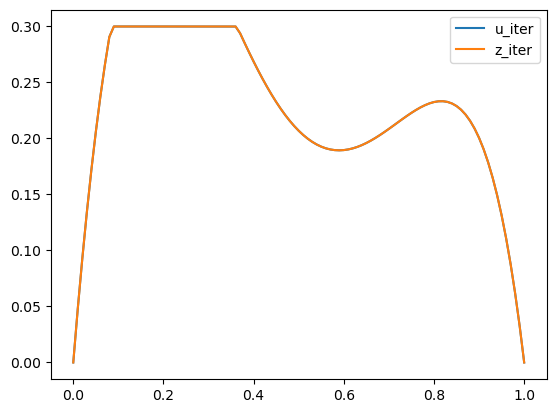

Done!37


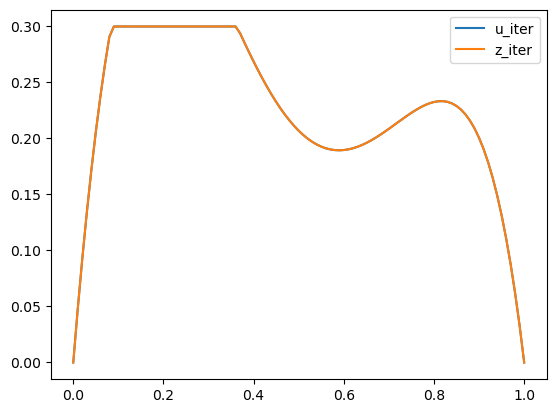

Done!38


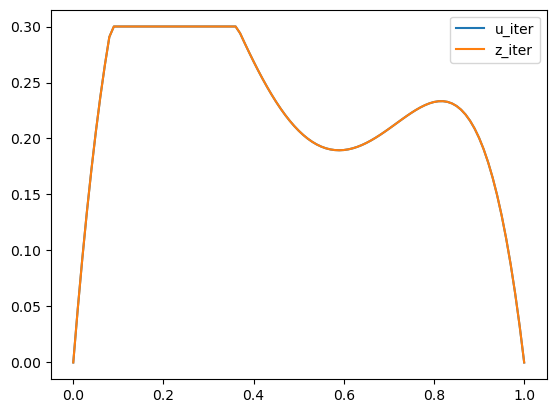

Done!39


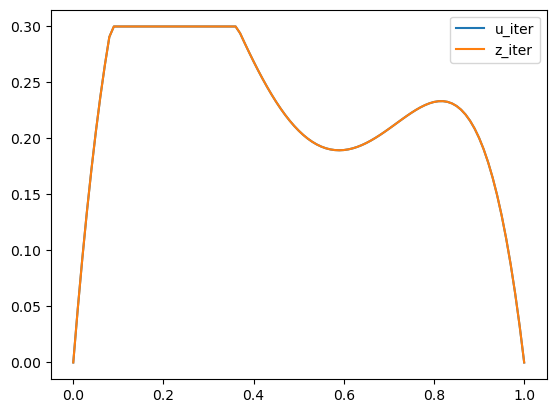

Done!40


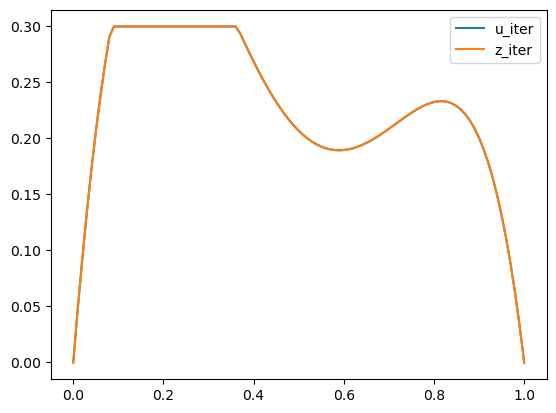

Done!41


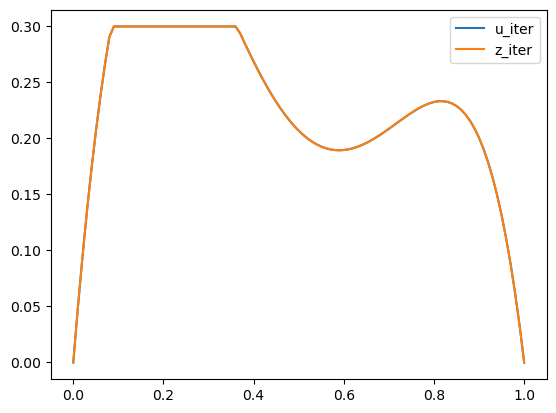

Done!42


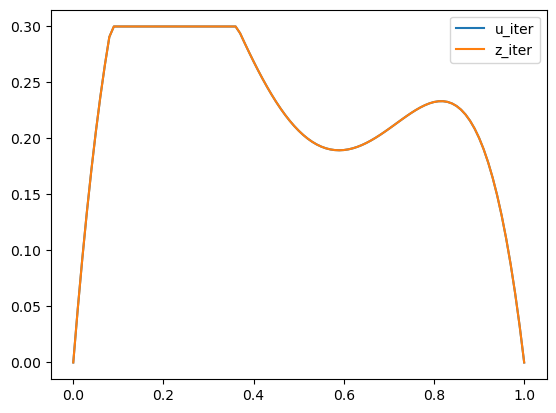

Done!43


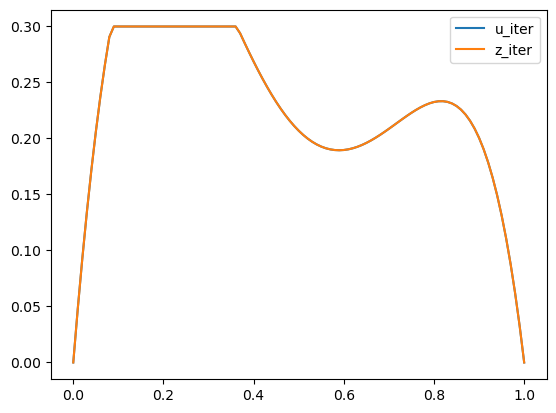

Done!44


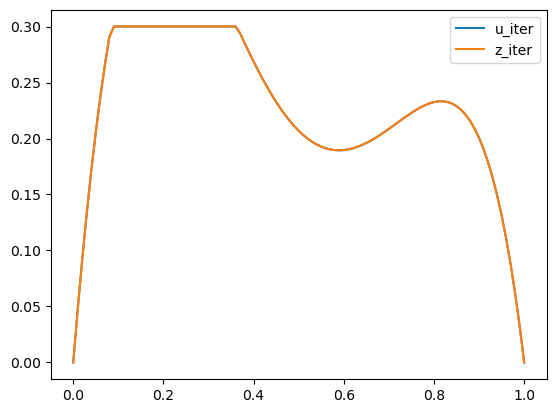

Done!45


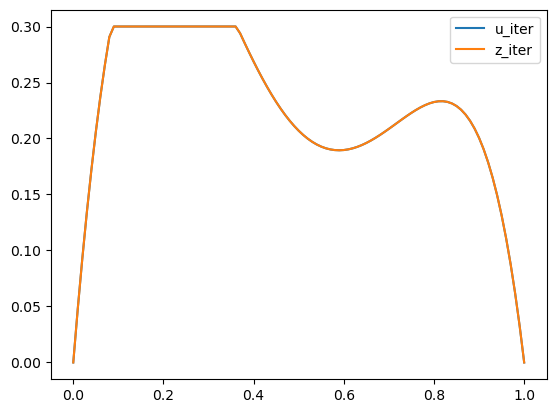

Done!46


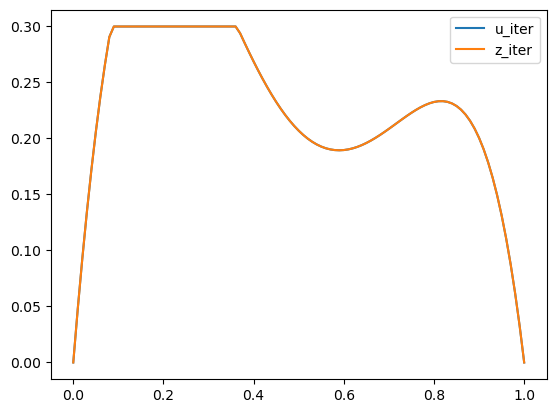

Done!47


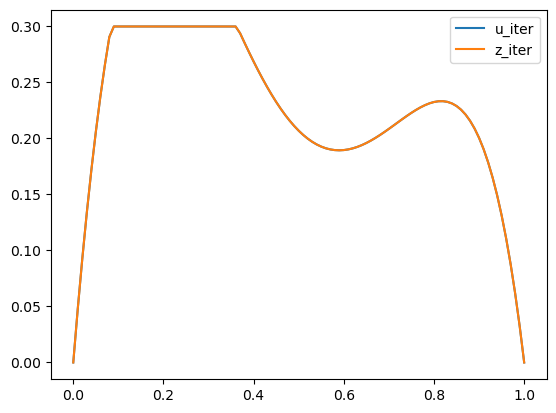

Done!48


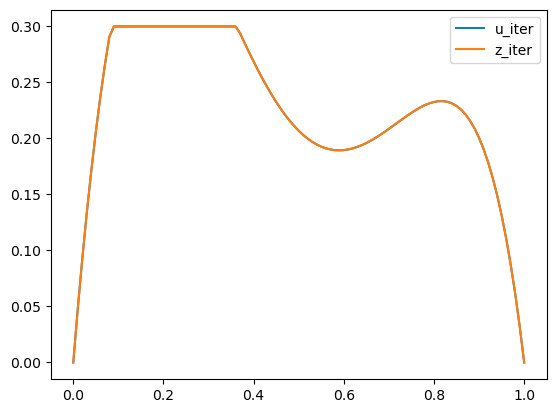

Done!49


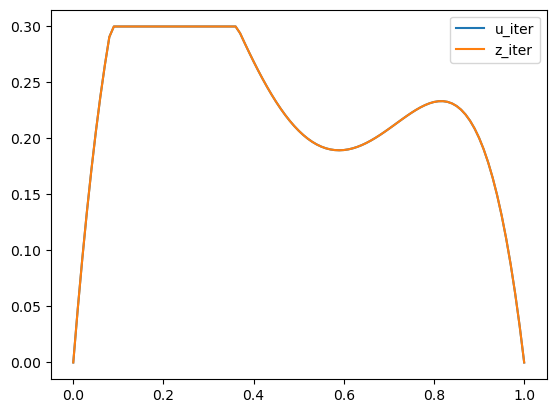

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 25 14:16:32 2022

@author: yuehr
"""

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

"geom"
class Space1d():
    def __init__(self,a,b):
        self.a=a
        self.b=b

    # def on_boundary(self,xt):
    #     return np.any(np.isclose(xt[:, :-1], [self.a, self.b]), axis=-1)
    # def on_initial(self,xt):
    #     return np.isclose(xt[:, -1:],self.t0).flatten()
    def uniform_points(self,n,boundary=True):
        if boundary:
            x=np.linspace(self.a, self.b, num=n)[:, None]
        else:
            x=np.linspace(self.a, self.b, num=n+1,endpoint=False)[1:, None]
        return x
    def random_points(self,nx):
        xr=np.random.rand(nx)[:, None]
        x=(self.b-self.a)*xr+self.a
        return x
    def uniform_boundary_points(self):
        return np.vstack((self.a, self.b))
N = 100
h = 1/N
domain=Space1d(0,1)
N=100
n=N+1
x=domain.uniform_points(n)
x_torch=torch.from_numpy(x).to(torch.float32).clone()
    
"model"
zd=0.3
nu=1/12
alpha=0.1
b=0.3
def yd_torch(x_torch):
    return 0*x_torch+zd
def BC_torch(x_torch):
    return 0*x_torch
"Network"
device =  "cpu"
print(f"Using {device} device")
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # self.flatten = nn.Flatten()
        self.yy = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        self.linear_Tanh_stack_p = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.yy(x)*x*(1-x),self.linear_Tanh_stack_p(x)*x*(1-x)
        # logits = self.linear_Tanh_stack_q(x),self.uu(x),self.vv(x)
        return logits
model = NeuralNetwork().to(device)
loss_fn = nn.MSELoss()
"trainning function"
Quiet=True
def train(model, loss_fn, optimizer):
    optimizer.zero_grad()
    loss = data.losses(model, loss_fn)
    loss.backward()
    optimizer.step()
    # loss= loss.item()
    if not Quiet:
        print(f"loss: {loss:>7f} ") 
def train_BFGS( model, loss_fn, optimizer):
    def closure():
        optimizer.zero_grad()
        loss = data.losses(model, loss_fn)
        loss.backward()
        return loss
    optimizer.step(closure)
    loss= closure().item()
    if not Quiet:
        print(f"loss: {loss:>7f} ") 
"""
ADMM
"""
# def pde(x_torch,y_torch,u_torch,u_prox):
#     "primal"
#     x_np=x_torch.cpu().detach().numpy()
#     x_np=np.round(x*(n-1))
#     i_a=np.int32(x_np)
#     u_prox_p=u_prox[i_a,0]
#     u_prox_torch=torch.from_numpy(u_prox_p).to(torch.float32).clone()
    
#     dy=torch.autograd.grad(y_torch, x_torch, grad_outputs=torch.ones_like(y_torch), create_graph=True)[0]
#     ddy=torch.autograd.grad(dy, x_torch, grad_outputs=torch.ones_like(dy), create_graph=True)[0]
#     error_pde=-nu*ddy+dy*y_torch-u_torch
#     error_prox=np.sqrt(beta)*(u_torch-u_prox_torch)+np.sqrt(alpha)*u_torch
#     error_yd=(y_torch-yd_torch(x_torch))
#     return torch.vstack((error_pde,error_yd,error_prox))        
class Burgers():
    def __init__(
        self,
        geometry,
        pde,
        bcs,
        u_prox,
        num_domain,
        para_bd,
    ):
        self.geom = geometry
        self.pde = pde
        self.para_bd=para_bd
        self.BC_torch = bcs
        self.u_prox=u_prox
        self.num_domain=num_domain
        
    def losses(self, model, loss_fn,random=False):
        if random:
            data_point=torch.from_numpy(self.geom.random_points(self.num_domain))
        else:
            data_point=torch.from_numpy(self.geom.uniform_points(self.num_domain))    
        x=data_point.to(torch.float32).clone().detach().requires_grad_(True)
        y= model(x)[0]
        p= model(x)[1]
        error_domain=self.pde(x,y,p,self.u_prox)
#         x_DBC=torch.from_numpy(self.geom.uniform_boundary_points()).to(torch.float32).clone()
#         error_DBC=model(x_DBC)[0]-self.BC_torch(x_DBC)
#         dual_DBC=model(x_DBC)[0]
#         pred=torch.vstack((error_domain,self.para_bd*error_DBC,self.para_bd*dual_DBC))
        pred=error_domain
        loss = loss_fn(pred, torch.zeros_like(pred))
        return loss
    
def kkt(x_torch,y_torch,p_torch,u_prox):
    x_np=x_torch.cpu().detach().numpy()
    x_np=np.round(x*(n-1))
    i_a=np.int32(x_np)
    u_prox_p=u_prox[i_a,0]
    u_prox_torch=torch.from_numpy(u_prox_p).to(torch.float32).clone()
    "opt"
    u_torch=(-p_torch+beta*u_prox_torch)/(alpha+beta)
    "primal"
    dy=torch.autograd.grad(y_torch, x_torch, grad_outputs=torch.ones_like(y_torch), create_graph=True)[0]
    ddy=torch.autograd.grad(dy, x_torch, grad_outputs=torch.ones_like(dy), create_graph=True)[0]
    primal=-nu*ddy+dy*y_torch-u_torch
    "dual"
    dp=torch.autograd.grad(p_torch, x_torch, grad_outputs=torch.ones_like(p_torch), create_graph=True)[0]
    ddp=torch.autograd.grad(dp, x_torch, grad_outputs=torch.ones_like(dp), create_graph=True)[0]
    dual=-nu*ddp-dp*y_torch-(y_torch-yd_torch(x_torch))
    return torch.vstack((primal,dual))


beta=0.1
u_iter=0*x
z_iter=u_iter
dual_iter=0*x
for i_outer in range(20):
    "k subproblem"
    u_prox=z_iter+dual_iter/beta
        
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    data = Burgers(domain,kkt,BC_torch,u_prox,num_domain=n,para_bd=1)
    epochs =5000
    for t in range(epochs):
#         print(f"Epoch {t+1}\n-------------------------------")
        train(model, loss_fn, optimizer)
    print(f"Done!{i_outer}")    
    optimizer = torch.optim.LBFGS(model.parameters(), lr=1, max_iter=1000, max_eval=None, tolerance_grad=1e-09, tolerance_change=1e-09, history_size=100, line_search_fn= 'strong_wolfe' )
    epochs =1
    for t in range(epochs):
#         print(f"Epoch {t+1}\n-------------------------------")
        train_BFGS(model, loss_fn, optimizer)
#     print("Done!")
    "z subproblem"
    y=model(x_torch)[0]
    y_iter=y.cpu().detach().numpy()
    p=model(x_torch)[1]
    p_iter=p.cpu().detach().numpy()
    u_iter=(-p_iter+beta*u_prox)/(alpha+beta)
    u_temp=u_iter-dual_iter/beta
    z_iter=np.where(u_temp<=b,u_temp,b)
    plt.figure()
    plt.plot(x, u_iter, "-", label="u_iter")
    plt.plot(x, z_iter, "-", label="z_iter")
    plt.legend()
    plt.show()
    "dual update"
    dual_iter=dual_iter-beta*(u_iter-z_iter)

y=model(x_torch)[0]
p=model(x_torch)[1]
y_iter=y.cpu().detach().numpy()
p_iter=p.cpu().detach().numpy()
# u_iter=(-p_iter+u_prox)/(alpha+beta)

# plt.figure()
# plt.plot(x, u_iter, "-", label="u")
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(x, y_iter, "--", label="y")
# plt.legend()
# plt.show()


In [8]:
x.tofile("x_plot_PINN_kkt.bin")
u_iter.tofile("u_PINN_kkt.bin")
y_iter.tofile("y_PINN_kkt.bin")
print(y_iter.dtype)

float32


In [9]:
x_direct=np.fromfile("x_plot_PINN_direct.bin",dtype=np.float64)
u_direct=np.fromfile("u_PINN_direct.bin",dtype=np.float32)
y_direct=np.fromfile("y_PINN_direct.bin",dtype=np.float32)